# Trades Example

Use with the following artifacts:
    1) trades.xml
    2) traders.xml
    3) trades.csv
    4) traders.csv
    5) eventgenerator.xml

The first step is to import the ESPPy package.

In [1]:
import esppy

Start an ESP server before running the next cell.  Enter the appropriate ('http:host:port') as the argument to the ESP constructor.

In [56]:
server=esppy.ESP('<host>:<port>')
server

In [3]:
server.server_info

{'analytics-license': True,
 'engine': 'esp',
 'http': 54321,
 'pubsub': 64321,
 'version': '5.2'}

List any projects that are active on the server. If you have not loaded projects to the server, this returns an empty dictionary.

In [4]:
server.get_projects()

{}

List windows within the project.  If you have not loaded projects to the server, this returns an empty dictionary.

In [5]:
server.get_windows()

{}

In [8]:
project_path = '<path>/trades.xml'
project_xml = project_path

Load the project 'trades_proj' into the esppy server session

In [9]:
trades_project = server.load_project(project_xml, name='trades_proj')

Confirm that the project 'trades_proj' has been successfully uploaded to the esp server

In [10]:
server.get_projects()

{'trades_proj': Project(name='trades_proj')}

In [11]:
server.get_windows()

{'trades_proj.trades_cq.AddTraderName': JoinWindow(name='AddTraderName', contquery='trades_cq', project='trades_proj'),
 'trades_proj.trades_cq.BySecurity': AggregateWindow(name='BySecurity', contquery='trades_cq', project='trades_proj'),
 'trades_proj.trades_cq.LargeTrades': FilterWindow(name='LargeTrades', contquery='trades_cq', project='trades_proj'),
 'trades_proj.trades_cq.TotalCost': ComputeWindow(name='TotalCost', contquery='trades_cq', project='trades_proj'),
 'trades_proj.trades_cq.Traders': SourceWindow(name='Traders', contquery='trades_cq', project='trades_proj'),
 'trades_proj.trades_cq.Trades': SourceWindow(name='Trades', contquery='trades_cq', project='trades_proj')}

List only the windows that are contained in the 'trades_proj' project

In [12]:
trades_project.get_windows()

{'AddTraderName': JoinWindow(name='AddTraderName', contquery='trades_cq', project='trades_proj'),
 'BySecurity': AggregateWindow(name='BySecurity', contquery='trades_cq', project='trades_proj'),
 'LargeTrades': FilterWindow(name='LargeTrades', contquery='trades_cq', project='trades_proj'),
 'TotalCost': ComputeWindow(name='TotalCost', contquery='trades_cq', project='trades_proj'),
 'Traders': SourceWindow(name='Traders', contquery='trades_cq', project='trades_proj'),
 'Trades': SourceWindow(name='Trades', contquery='trades_cq', project='trades_proj')}

Output a list of only the continuous queries that are in the 'trades_project' project 

In [13]:
trades_project.queries

{'trades_cq': ContinuousQuery(name='trades_cq', project='trades_proj')}

List all windows that are a part of the continuous query, 'trades_cq'

In [14]:
trades_project.queries['trades_cq'].windows

{'Trades': SourceWindow(name='Trades', contquery='trades_cq', project='trades_proj'), 'Traders': SourceWindow(name='Traders', contquery='trades_cq', project='trades_proj'), 'LargeTrades': FilterWindow(name='LargeTrades', contquery='trades_cq', project='trades_proj'), 'AddTraderName': JoinWindow(name='AddTraderName', contquery='trades_cq', project='trades_proj'), 'TotalCost': ComputeWindow(name='TotalCost', contquery='trades_cq', project='trades_proj'), 'BySecurity': AggregateWindow(name='BySecurity', contquery='trades_cq', project='trades_proj')}

Produce a graphical representation of the continuous query, 'trades_cq' 

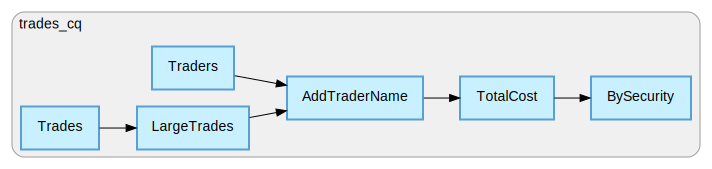

In [15]:
trades_project.queries['trades_cq']

Display the XML of the project

In [16]:
print(trades_project.to_xml(pretty=True))

<engine>
  <projects>
    <project name="trades_proj" pubsub="auto" threads="4">
      <contqueries>
        <contquery name="trades_cq">
          <windows>
            <window-join name="AddTraderName">
              <join type="leftouter">
                <conditions>
                  <fields left="traderID" right="ID" />
                </conditions>
              </join>
              <output>
                <field-selection name="security" source="l_security" />
                <field-selection name="quantity" source="l_quantity" />
                <field-selection name="price" source="l_price" />
                <field-selection name="traderID" source="l_traderID" />
                <field-selection name="time" source="l_time" />
                <field-selection name="name" source="r_name" />
              </output>
            </window-join>
            <window-aggregate name="BySecurity">
              <schema>
                <fields>
                  <field key="true" nam

Create a new project named 'my_proj'

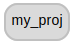

In [17]:
my_project=server.create_project('my_proj')
my_project

Add a continuous query called 'trades_cq' to the project

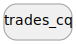

In [18]:
my_query = my_project.add_query('trades_cq')
my_query

Continue to build your project by adding a source window called 'Trades' to the project. 

Specify any input variables in the schema along with their datatype. You may choose to add a key to a variable by placing a * after its name.

After creating the window, display an image of it.

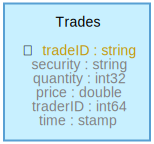

In [19]:
source_trades = server.SourceWindow(name='Trades',
                                   schema=('tradeID*:string', 'security:string', 'quantity:int32', 'price:double', 'traderID:int64', 'time:stamp'),
                                   index_type='pi_RBTREE')

source_trades

Add the source window'Trades' to the continuous query 'trades_cq'.  Then display an image of the project so far.

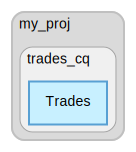

In [20]:
my_query.add_window(source_trades)

my_project

Create another source window that receives data about the Traders. Name this new window 'Traders'.
Note that the input variable tradesID is specified to be a key.  Then display an image of the Source window 'Traders'.

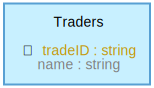

In [21]:
source_traders = server.SourceWindow(name='Traders', schema=('tradeID*:string', 'name:string'))

source_traders

Make a FilterWindow called 'Large Trades'. Add an expression to the FilterWindow, that defines what data passes through it. In this case, let Large trades that have a quantity that is at least 100 pass through.

In [22]:
filter_large = server.FilterWindow(name='LargeTrades')

filter_large.set_expression('quantity >= 100')

Create a JoinWindow called 'AddTraderName' and specify the type of join as well as the join conditions.
Define field selections and specify the variable pairs to be joined.
Place 'l_' before all variables that come from the left join, and 'r_' before those from the right join.
Display the field selections.  Then run a loop to perform the actual join.

In [23]:
join = server.JoinWindow(name='AddTraderName', type='leftouter', conditions=[('tradeID', 'tradeID')])


field_selections = [['security', 'l_security'], ['quantity', 'l_quantity'], ['price', 'l_price'], ['traderID', 'l_traderID'], ['time', 'l_time'], ['name', 'r_name']]

field_selections

for i in range(len(field_selections)):
    join.add_field_selection(field_selections[i][0], field_selections[i][1])

Add a compute window to the project called 'TotalCost' to calculate price*quantity.
Though the variable totalCost does not exist yet, you must specify it in the output schema. 
Additionally, in the schema you must include any variables that are needed to perform the calculation
Then, add field expressions that define how each variable in your output schema is created.
Notice that variables are created in the order that they were specified in your output schema. 

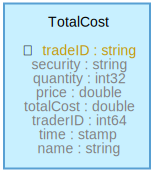

In [24]:
compute = server.ComputeWindow(name='TotalCost',
schema=('tradeID*:string', 'security:string', 'quantity:int32',
'price:double', 'totalCost:double', 'traderID:int64',
'time:stamp', 'name:string'))

compute.add_field_expressions('security', 'quantity', 'price', 'price*quantity', 'traderID', 'time', 'name')

compute

Add an aggregate window to our project, and call it 'BySecurity'. In this window you compute quantityTotal and costTotal. Most importantly, the calculations are done by the specified key value, security*.
Add field expressions to the calculate window to declare how the values in the output schema are computed. Here, you calculate the 'quantityTotal' by 'ESP_aSum(quantity)', and 'costTotal' by 'ESP_aSum(totalCost)'.  Then display the aggregate window along with its schema.

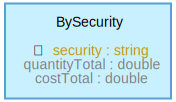

In [25]:
aggregate = server.AggregateWindow(name='BySecurity', schema=('security*:string', 'quantityTotal:double',
'costTotal:double'))

aggregate.add_field_expressions('ESP_aSum(quantity)', 'ESP_aSum(totalCost)')

aggregate

Assemble the project by defining edges between each of the windows.
Create an edge between the 'Trades' Source window and the 'LargeTrades' Filter window with the data role.
Create an edge between the filterWindow 'LargeTrades' and the the join window 'AddTraderName' with the role 'left', specifying the left join.
Create an edge between the source window, 'Traders' and the join window 'AddTraderName' with the role 'right', specifying the right join.
Create an edge between the join window 'AddTraderName' and the compute window, 'TotalCost' with the data role. 
Create an edge between the aggregate window, 'BySecurity' and the compute window, 'TotalCost' with the data role.

In [26]:
source_trades.add_target(filter_large, role='data')
filter_large.add_target(join, role='left') 
source_traders.add_target(join, role='right')
join.add_target(compute, role='data') 
compute.add_target(aggregate, role='data')

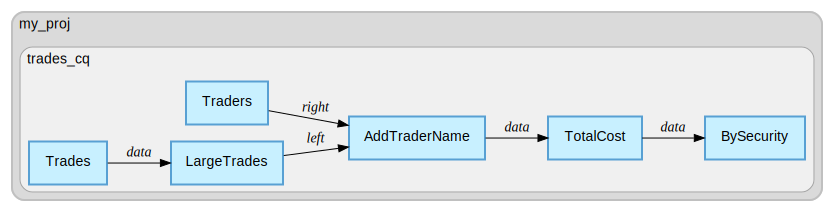

In [27]:
my_query.add_windows(source_trades, source_traders, filter_large, join, compute, aggregate)

my_project

In [28]:
server.load_project(my_project)
server.get_projects()

{'my_proj': Project(name='my_proj'),
 'trades_proj': Project(name='trades_proj')}

In [29]:
print(my_project.to_xml(pretty=True))

<engine>
  <projects>
    <project name="my_proj" pubsub="auto" threads="1">
      <contqueries>
        <contquery name="trades_cq">
          <windows>
            <window-join name="AddTraderName">
              <join type="leftouter">
                <conditions>
                  <fields left="tradeID" right="tradeID" />
                </conditions>
              </join>
              <output>
                <field-selection name="security" source="l_security" />
                <field-selection name="quantity" source="l_quantity" />
                <field-selection name="price" source="l_price" />
                <field-selection name="traderID" source="l_traderID" />
                <field-selection name="time" source="l_time" />
                <field-selection name="name" source="r_name" />
              </output>
            </window-join>
            <window-aggregate name="BySecurity">
              <schema>
                <fields>
                  <field key="true" nam

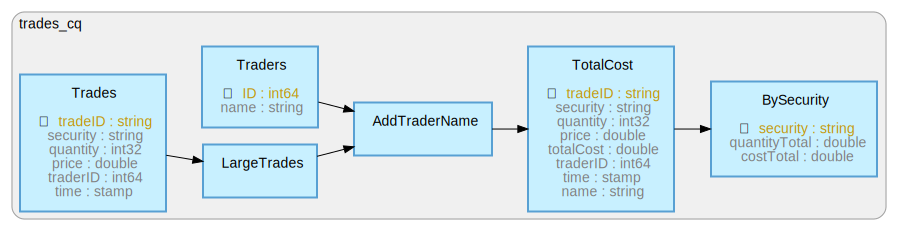

In [30]:
trades_project['trades_cq'].to_graph(schema=True)

In [31]:
print(trades_project['trades_cq']['Traders'].to_xml(pretty=True))

<window-source name="Traders">
  <schema>
    <fields>
      <field key="true" name="ID" type="int64" />
      <field key="false" name="name" type="string" />
    </fields>
  </schema>
</window-source>



The code that follows explores two methods for publishing data into the project. 
The first publishes data from a .csv file into a source window.
Begin by opening and reading a file that contains trades data.

In [33]:
trades_csv = open('<path>/trades.csv').read()

Next, open and read a file that contains traders data.

In [34]:
traders_csv = open('<path>/traders.csv').read()

Use print to confirm that the data on trades has been read 

In [35]:
print(trades_csv)

i,n,TID1234321,ibm,1000,100.1,10002,08/Jul/2012:08:10:00.000000
i,n,TID1234322,sap,750,34.2,10003,08/Jul/2012:08:10:01.000345
i,n,TID1234323,ibm,1000,100.2,10004,08/Jul/2012:08:10:12.000001
i,n,TID1234324,ibm,1000,100.3,10004,08/Jul/2012:08:10:13.000002
i,n,TID1234325,ibm,1000,100.4,10004,08/Jul/2012:08:10:13.000002
i,n,TID1234326,sap,1000,34.3,10003,08/Jul/2012:08:10:13.000003
i,n,TID1234327,ibm,1000,100.3,10002,08/Jul/2012:08:10:13.000004
i,n,TID1234328,sap,1000,32,10003,08/Jul/2012:08:10:13.000005
i,n,TID1234329,ibm,1000,100,10004,08/Jul/2012:08:10:13.000006
i,n,TID1234330,sap,90,32,10003,08/Jul/2012:08:10:13.000011
i,n,TID1234331,ibm,80,100.3,10004,08/Jul/2012:08:10:13.000012



Isolate the two source windows('Trades' and 'Traders') into which data is published.

In [36]:
w_trades = trades_project['trades_cq']['Trades']
w_traders = trades_project['trades_cq']['Traders']

Publish data into the 'Trades' and 'Traders' source windows

In [37]:
w_trades.publish_events(trades_csv, dateformat='%d/%b/%Y:%H:%M:%S', format='csv')
w_traders.publish_events(traders_csv, format='csv')

Confirm that the data has been published into the 'Trades' source window

In [38]:
w_trades.get_events()

,security,quantity,price,traderID,time
tradeID,,,,,
TID1234321,ibm,1000,100.1,10002,2012-07-08 08:10:00.000000
TID1234322,sap,750,34.2,10003,2012-07-08 08:10:01.000345
TID1234323,ibm,1000,100.2,10004,2012-07-08 08:10:12.000001
TID1234324,ibm,1000,100.3,10004,2012-07-08 08:10:13.000002
TID1234325,ibm,1000,100.4,10004,2012-07-08 08:10:13.000002
TID1234326,sap,1000,34.3,10003,2012-07-08 08:10:13.000003
TID1234327,ibm,1000,100.3,10002,2012-07-08 08:10:13.000004
TID1234328,sap,1000,32.0,10003,2012-07-08 08:10:13.000005
TID1234329,ibm,1000,100.0,10004,2012-07-08 08:10:13.000006


The second method to publish data is through a pre-defined event generator.
Define and read a separate xml file that contains the definitions for that is used to create the event generator 

In [41]:
EventGenerator_Path = '<path>/eventgenerator.xml' 
EventGenerator_xml = open(EventGenerator_Path).read() 

Use print to ensure that the event generator has been loaded 
Notice that this event generator is designed to inject events into the 'Trades' source window

In [40]:
print(EventGenerator_xml)

<event-generator name='trades_generator' insert-only='true' autogen-key='false'>
	<publish-target>dfESP://<host>:<pubsub-port>/trades_proj/trades_cq/Trades</publish-target>
	<init>
		<value name='ID'>0</value>
	</init>
	<fields>
		<field name='tradeID'>if(equals(0,$tradeID),increment($ID),increment($tradeID))</field>
		<field name='security'>randomParm('IBM', 'SAP')</field>
		<field name='quantity'>random(80,1000)</field>
		<field name='price'>if(equals($security,'IBM'),precision(random(100,101),1),precision(random(32,35),1))</field>
		<field name='traderID'>if(equals($security,'IBM'),randomParm(10002,10004),10003)</field>
		<field name='time'>systemMicro()</field>
	</fields>
</event-generator>


Formally create an event generator using the XML that was loaded.

In [53]:
trades_generator = esppy.evtgen.EventGenerator.from_xml(str(EventGenerator_xml)) 
trades_generator

In order to run an event generator, make sure that it is running in the same session as the model. After assigning the session, save the event generator.  Then initialize and start it.

In [43]:
trades_generator.session = server.session

trades_generator.save() 

trades_generator.initialize() 

trades_generator.start(rate=10) 

After events begin to stream in, retrieve them from the 'Trades' source window

In [44]:
w_trades2 = trades_project['trades_cq']['Trades'] 
w_trades2.get_events()

,security,quantity,price,traderID,time
tradeID,,,,,
1,IBM,193,101.0,10004,2018-10-19 18:10:47.893464
2,SAP,910,34.0,10003,2018-10-19 18:10:47.894363
3,SAP,699,33.0,10003,2018-10-19 18:10:47.894491
4,IBM,531,100.0,10004,2018-10-19 18:10:47.894599
5,IBM,201,100.0,10004,2018-10-19 18:10:47.894695
6,SAP,215,32.0,10003,2018-10-19 18:10:47.894791
7,IBM,327,101.0,10004,2018-10-19 18:10:47.894907
8,SAP,650,32.0,10003,2018-10-19 18:10:47.895025
9,IBM,398,101.0,10004,2018-10-19 18:10:47.895127


When you specify a streaming chart, it creates an independent subscriber to the associated window. Thus, you do not need to subscribe to that window on a separate line of code beforehand.

In [45]:
from esppy.plotting import StreamingChart 
w_BySecurity=trades_project['trades_cq']['BySecurity']  

streamChart = w_BySecurity.streaming_bar('security', 'quantityTotal', title='Total Quantity Sold By Security')
streamChart

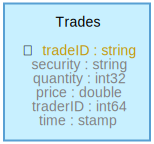

In [46]:
w_trades2 = trades_project['trades_cq']['Trades']
w_trades2.subscribe()
w_trades2

In [47]:
w_trades2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86 entries, 301 to 386
Data columns (total 5 columns):
security    86 non-null object
quantity    86 non-null int32
price       86 non-null float64
traderID    86 non-null int64
time        86 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(1)
memory usage: 3.7+ KB


In [48]:
w_trades2.head()

,security,quantity,price,traderID,time
tradeID,,,,,
301,IBM,914,101.0,10004,2018-10-19 18:11:18.059185
302,IBM,746,101.0,10004,2018-10-19 18:11:18.060227
303,IBM,844,100.0,10002,2018-10-19 18:11:18.060370
304,SAP,444,35.0,10003,2018-10-19 18:11:18.060516
305,SAP,577,32.0,10003,2018-10-19 18:11:18.060644


In [49]:
w_trades2.describe()

,quantity,price,traderID
count,180.000000,180.000000,180.000000
mean,540.566667,65.477778,10002.977778
std,258.738627,33.601585,0.692784
min,82.000000,32.000000,10002.000000
25%,298.000000,33.000000,10002.750000
50%,567.000000,35.000000,10003.000000
75%,760.500000,100.000000,10003.000000
max,997.000000,101.000000,10004.000000


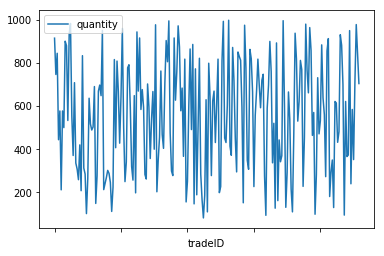

In [50]:
%matplotlib inline

w_trades2.plot(y='quantity')

In [51]:
w_trades2.streaming_bar(x='time', y=['quantity', 'price'])

In [52]:
trades_generator.stop()
trades_generator.delete()